# Expert Knowledge Worker

In [26]:
!pip install chardet

In [120]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

# imports for langchain and Chroma and plotly

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
#from langchain_chroma import Chroma
from langchain.vectorstores import FAISS
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

In [121]:
MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [122]:
# Load environment variables in a file called .env

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [123]:
folders = glob.glob("knowledge-base/*")
text_loader_kwargs = {'encoding': 'utf-8', 'autodetect_encoding': True}
# With thanks to Jon R, a student on the course, for this fix needed for some users 
text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

print(f"Total number of chunks: {len(chunks)}")
print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")

Total number of chunks: 123
Document types found: {'products', 'company', 'employees', 'contracts'}


In [124]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [125]:
len(chunks)

123

In [126]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: products, company, employees, contracts


# A sidenote on Embeddings, and "Auto-Encoding LLMs"

I will be mapping each chunk of text into a Vector that represents the meaning of the text, known as an embedding.

OpenAI offers a model to do this, which we will use by calling their API with some LangChain code.

This model is an example of an "Auto-Encoding LLM" which generates an output given a complete input.
It's different then "Auto-Regressive LLMs", and generate future tokens based only on past context.

Another example of an Auto-Encoding LLMs is BERT from Google. In addition to embedding, Auto-encoding LLMs are often used for classification.

In [127]:
embeddings = OpenAIEmbeddings()

# Delete if already exists

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore
#Added Chroma
vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

#Added FAISS
# vectorstore = FAISS.from_documents(chunks, embedding=embeddings)

# total_vectors = vectorstore.index.ntotal
# dimensions = vectorstore.index.d
# print(f"There are {total_vectors} vectors with {dimensions:,} dimensions in the vector store")


Vectorstore created with 123 documents


In [134]:
#Code for Chroma database
collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")


#Code for FISS
# vectors = []
# documents = []
# doc_types = []
# colors = []
# color_map = {'products':'blue', 'employees':'green', 'contracts':'red', 'company':'orange'}

# for i in range(total_vectors):
#     vectors.append(vectorstore.index.reconstruct(i))
#     doc_id = vectorstore.index_to_docstore_id[i]
#     document = vectorstore.docstore.search(doc_id)
#     documents.append(document.page_content)
#     doc_type = document.metadata['doc_type']
#     doc_types.append(doc_type)
#     colors.append(color_map[doc_type])
    
# vectors = np.array(vectors)


There are 123 vectors with 1,536 dimensions in the vector store


In [135]:
sample_embedding

array([-0.0177716 ,  0.00710593, -0.02663709, ..., -0.0127433 ,
       -0.00526516, -0.0274898 ])

# Visualizing the Vector Store

In [136]:
# Code for Chroma
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

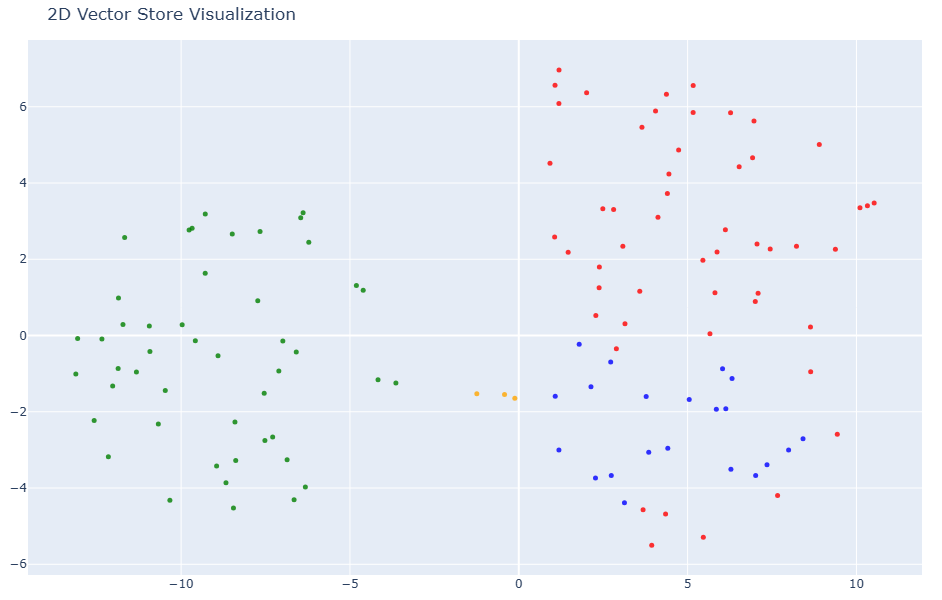

In [137]:
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

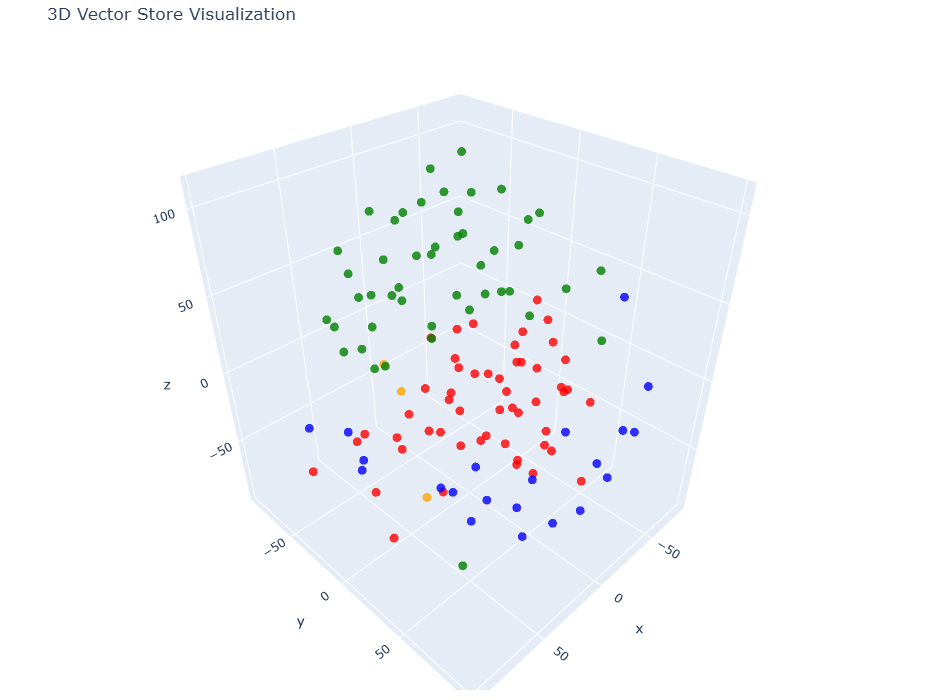

In [138]:
tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

# LangChain to bring it all together

In [139]:
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [140]:
query = "Can you describe Insurellm in a few sentences"
result = conversation_chain.invoke({"question":query})
print(result["answer"])

Insurellm is an innovative insurance tech firm founded in 2015 by Avery Lancaster, designed to disrupt the insurance industry with its cutting-edge products. The company offers four software products: Carllm for auto insurance, Homellm for home insurance, Rellm for the reinsurance sector, and Marketllm, a marketplace connecting consumers with insurance providers. With 200 employees and over 300 clients worldwide, Insurellm has established a strong presence across the US, focusing on transforming the insurance landscape through technology.


# Applying a Gradio interface

In [141]:
def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [142]:
view = gr.ChatInterface(chat).launch()

C:\Users\QIRAT\anaconda3\envs\llms\Lib\site-packages\gradio\components\chatbot.py:229: UserWarning:

The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.



* Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.


In [143]:
# Let's investigate what gets sent behind the scenes

from langchain_core.callbacks import StdOutCallbackHandler

llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever()

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])

query = "Who received the prestigious IIOTY award in 2023?"
result = conversation_chain.invoke({"question": query})
answer = result["answer"]
print("\nAnswer:", answer)



> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
- **2022**: **Satisfactory**  
  Avery focused on rebuilding team dynamics and addressing employee concerns, leading to overall improvement despite a saturated market.  

- **2023**: **Exceeds Expectations**  
  Market leadership was regained with innovative approaches to personalized insurance solutions. Avery is now recognized in industry publications as a leading voice in Insurance Tech innovation.

## Annual Performance History
- **2020:**  
  - Completed onboarding successfully.  
  - Met expectations in delivering project milestones.  
  - Received positive feedback from the team leads.

- **2021:**  
  - Achieved a 95% success rate in proj

In [144]:
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG; k is how many chunks to use
retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [145]:
def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [146]:
view = gr.ChatInterface(chat).launch()

C:\Users\QIRAT\anaconda3\envs\llms\Lib\site-packages\gradio\components\chatbot.py:229: UserWarning:

The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.



* Running on local URL:  http://127.0.0.1:7876

To create a public link, set `share=True` in `launch()`.
